In [27]:
# Importing Libraries
import pandas as pd
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading global stock price data for exxon mobil
global_stock_exxon = pd.read_csv('final_global_stock_price_for_exxon.csv',index_col='Date',parse_dates=True)
global_stock_exxon.sort_index(inplace = True)
global_stock_exxon_start_date = global_stock_exxon.index[0]
global_stock_exxon_end_date = global_stock_exxon.index[-1]

## JODI DATA PREPARATION FOR TRAINING WITH STOCK PRICE VALUE

In [3]:
# Loading the JODI Data and retrieving the segment of use
jodi_data = pd.read_csv('new_jodi.csv',index_col = 'Date', parse_dates = True)
jodi_data.sort_index(inplace = True)
jodi_data.drop(jodi_data.filter(regex="Unname"),axis=1, inplace=True)
jodi_data_segment = jodi_data[global_stock_exxon_start_date:global_stock_exxon_end_date]
jodi_data_segment_start_date = jodi_data_segment.index[0]
jodi_data_segment_end_date = jodi_data_segment.index[-1]

In [4]:
# Removing the unecessary columns from JODI Data
jodi_column_list = jodi_data_segment.columns
drop_columns_list = jodi_column_list[-15:]
jodi_data_segment.drop(columns = drop_columns_list, inplace = True)

In [5]:
# Using Rolling Mean to handle the NaN values present in the data
for j in range(6):
    for i in jodi_data_segment.columns:
        jodi_data_segment['{}_Avg'.format(i)] = jodi_data_segment[i].rolling(1000,min_periods = 1,center = True).mean()
        for j in jodi_data_segment.index:
            if np.isnan(jodi_data_segment[i][j]):
                jodi_data_segment[i][j] = jodi_data_segment['{}_Avg'.format(i)][j]
        jodi_data_segment = jodi_data_segment.drop(columns = ['{}_Avg'.format(i)])

In [6]:
# Creating the segment of stock data such that both the data are in same timeframe 
stock_data_exxon_segment = global_stock_exxon[jodi_data_segment_start_date:jodi_data_segment_end_date]

In [7]:
# Creating final data that is used for training the model which gives the impact of JODI Data on Stock Price Value
combined_column_list = []
for i in jodi_data_segment.columns:
    combined_column_list.append(i)
for i in stock_data_exxon_segment.columns:
    combined_column_list.append(i)

In [8]:
# Creating Joint data of JODI and Stock Price Value
jodi_vs_stock_exxon_data = pd.DataFrame()
for i in combined_column_list:
    if i == 'Value':
        jodi_vs_stock_exxon_data[i] = stock_data_exxon_segment['Value']        
    elif i == 'Data Present':
        jodi_vs_stock_exxon_data[i] = stock_data_exxon_segment['Data Present']
    else:
        jodi_vs_stock_exxon_data[i] = jodi_data_segment[i]

In [9]:
# Function for Spliting the data into Training-Validation-Testing Data with split ratio as 80-10-10

def train_valid_test_split(dataset):
    tr_size=int((dataset.shape[0])*0.8)
    va_size=int((dataset.shape[0])*0.9)
    train = dataset[:tr_size]
    validation = dataset[tr_size:va_size]
    test = dataset[va_size:]
    return train,validation,test

In [10]:
# Spliting the data into Training-Validation-Testing Data with split ratio as 80-10-10
train, validation, test = train_valid_test_split(jodi_vs_stock_exxon_data)

In [11]:
# Getting the trainable features and label from the actual data

# Training Set
train_X = train.drop(columns=['Value'])
train_y = train['Value']

# Validation Set
validation_X = validation.drop(columns=['Value'])
validation_y = validation['Value']

# Testing Set
test_X = test.drop(columns=['Value'])
test_y = test['Value']

## Training LinearRegression Model to get linear impact of JODI on Stock Price of Exxon

In [12]:
# Importing LinearRegression Model from sklearn
from sklearn.linear_model import LinearRegression

In [13]:
# Creating and Fitting the linear model on Training Set of the data
linear_model = LinearRegression()
linear_model.fit(train_X,train_y)

LinearRegression()

In [14]:
# Predicting the stock price value for exxon using linear model
pred_train_y = linear_model.predict(train_X)
pred_valid_y = linear_model.predict(validation_X)
pred_test_y = linear_model.predict(test_X)

In [15]:
# Using Root Mean Squared Error Metrics for Model Evaluation
from sklearn.metrics import mean_squared_error

rmse_train = np.sqrt(mean_squared_error(train_y,pred_train_y))
rmse_valid = np.sqrt(mean_squared_error(validation_y,pred_valid_y))
rmse_test = np.sqrt(mean_squared_error(test_y,pred_test_y))

rmse_train,rmse_valid,rmse_test

(1.5169097009875145, 910.0949487441195, 3374.2384784567016)

In [16]:
#Creating the target vs prediction dataframe for each set of data for linear model

train_result = pd.DataFrame()
train_result['target'] = train_y
train_result['predicted']=pred_train_y
train_result.to_csv('linear_model_train_result.csv')

validation_result = pd.DataFrame()
validation_result['target'] = validation_y
validation_result['predicted']=pred_valid_y
validation_result.to_csv('linear_model_validation_result.csv')

test_result = pd.DataFrame()
test_result['target'] = test_y
test_result['predicted']=pred_test_y
test_result.to_csv('linear_model_test_result.csv')

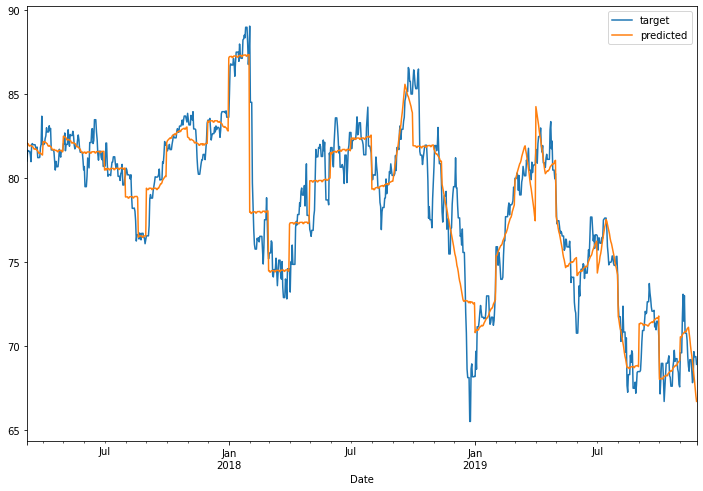

In [17]:
# Plotting the fit of prediction to the target of training data for linear model
train_result[['target','predicted']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

## Getting the feature importance of JODI Data using Permutation_Importance by Sklearn for Linear Model

In [18]:
from sklearn.inspection import permutation_importance

In [19]:
# Knowing the importance of each feature of JODI Data for linear model

linear = permutation_importance(linear_model,train_X, train_y,n_repeats=30,random_state=43)
for i in linear.importances_mean.argsort()[::-1]:
    if linear.importances_mean[i] - 2 * linear.importances_std[i] > 0:
        print(f"{combined_column_list[i]:<8}"
              f"{linear.importances_mean[i]:.3f}"
              f" +/- {linear.importances_std[i]:.3f}")

COSTA RICA4733.687 +/- 130.206
JAPAN   4483.580 +/- 133.373
TURKEY  2841.542 +/- 84.831
HONG KONG1259.272 +/- 36.726
CANADA  1086.930 +/- 41.500
ANGOLA  1078.211 +/- 32.669
INDONESIA1022.245 +/- 29.547
UNITED STATES938.812 +/- 30.928
POLAND  929.935 +/- 30.340
NIGERIA 759.644 +/- 22.325
CHINA   713.855 +/- 19.976
GREECE  557.495 +/- 17.789
ARGENTINA446.588 +/- 13.480
IRAQ    432.083 +/- 11.734
CHILE   389.702 +/- 9.248
ALGERIA 355.843 +/- 9.131
FRANCE  323.298 +/- 9.391
BULGARIA292.153 +/- 8.038
SPAIN   257.672 +/- 8.169
EL SAVADOR240.718 +/- 5.809
KUWAIT  239.278 +/- 7.350
SWEDEN  208.350 +/- 6.386
UKRAINE 166.580 +/- 6.210
BRAZIL  166.206 +/- 5.911
DOMINICAN REPUBLIC148.024 +/- 4.244
NORWAY  124.754 +/- 4.053
PORTUGAL109.998 +/- 3.170
GERMANY 107.828 +/- 2.552
SAUDI ARABIA103.342 +/- 2.733
SOUTH AFRICA102.479 +/- 3.338
BELGIUM 99.250 +/- 2.908
AUSTRALIA89.957 +/- 2.333
JAMAICA 76.620 +/- 2.399
ITALY   70.864 +/- 2.740
KOREA, REPUBLIC OF59.983 +/- 1.779
NETHERLANDS48.026 +/- 1.782
ECU

## Training RandomForestRegressor Model to get non-linear impact of JODI on Stock Price of Exxon

In [20]:
# Importing RandomForestRegressor Model from sklearn
from sklearn.ensemble import RandomForestRegressor

In [21]:
# Creating and Fitting the random forest model on Training Set of the data
rf_model = RandomForestRegressor()
rf_model.fit(train_X,train_y)

RandomForestRegressor()

In [22]:
# Predicting the stock price value for exxon using random forest model
pred_train_y_rf = rf_model.predict(train_X)
pred_valid_y_rf = rf_model.predict(validation_X)
pred_test_y_rf = rf_model.predict(test_X)

In [23]:
# Using Root Mean Squared Error Metrics for Model Evaluation

rmse_train_rf = np.sqrt(mean_squared_error(train_y,pred_train_y_rf))
rmse_valid_rf = np.sqrt(mean_squared_error(validation_y,pred_valid_y_rf))
rmse_test_rf = np.sqrt(mean_squared_error(test_y,pred_test_y_rf))

rmse_train_rf,rmse_valid_rf,rmse_test_rf

(0.30933359606384414, 16.505678405349055, 25.814590854170824)

In [24]:
#Creating the target vs prediction dataframe for each set of data for random forest model

train_result_rf = pd.DataFrame()
train_result_rf['target'] = train_y
train_result_rf['predicted']=pred_train_y_rf
train_result_rf.to_csv('random_forest_model_train_result.csv')

validation_result_rf = pd.DataFrame()
validation_result_rf['target'] = validation_y
validation_result_rf['predicted']=pred_valid_y_rf
validation_result_rf.to_csv('random_forest_model_validation_result.csv')

test_result_rf = pd.DataFrame()
test_result_rf['target'] = test_y
test_result_rf['predicted']=pred_test_y_rf
test_result_rf.to_csv('random_forest_model_test_result.csv')

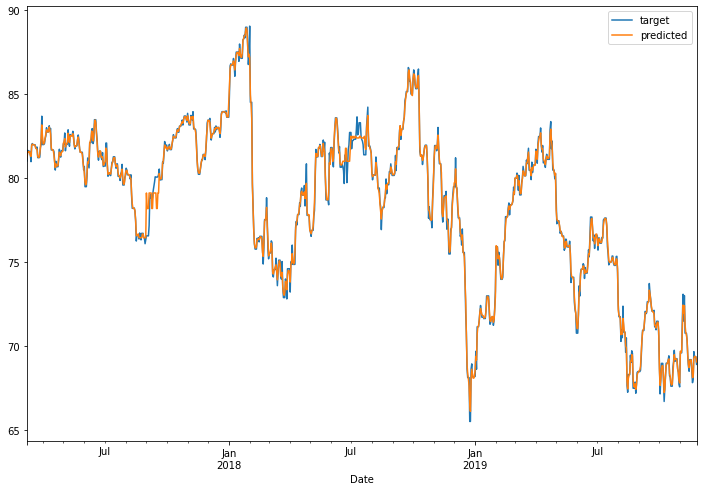

In [25]:
# Plotting the fit of prediction to the target of training data for random forest model
train_result_rf[['target','predicted']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

## Getting the feature importance of JODI Data using Permutation_Importance by Sklearn for Random Forest Model

In [26]:
# Knowing the importance of each feature of JODI Data for random forest model

rf = permutation_importance(rf_model,train_X, train_y,n_repeats=30,random_state=43)
for i in rf.importances_mean.argsort()[::-1]:
    if rf.importances_mean[i] - 2 * rf.importances_std[i] > 0:
        print(f"{combined_column_list[i]:<8}"
              f"{rf.importances_mean[i]:.3f}"
              f" +/- {rf.importances_std[i]:.3f}")

CHINA   0.528 +/- 0.024
EQUATORIAL GUINEA0.139 +/- 0.013
MEXICO  0.118 +/- 0.006
LUXEMBOURG0.076 +/- 0.006
INDIA   0.033 +/- 0.002
BELGIUM 0.032 +/- 0.002
EL SAVADOR0.028 +/- 0.002
COLOMBIA0.022 +/- 0.001
CZECH REPUBLIC0.016 +/- 0.001
PERU    0.014 +/- 0.001
BARBADOS0.009 +/- 0.001
SOUTH AFRICA0.009 +/- 0.001
QATAR   0.009 +/- 0.001
IRAN, ISLAMIC REPUBLIC OF0.005 +/- 0.000
MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF0.005 +/- 0.000
DOMINICAN REPUBLIC0.005 +/- 0.001
PORTUGAL0.005 +/- 0.001
AZERBAIJAN0.005 +/- 0.000
ARGENTINA0.003 +/- 0.000
TUNISIA 0.002 +/- 0.000
JAMAICA 0.002 +/- 0.000
UNITED KINGDOM0.001 +/- 0.000
UNITED ARAB EMIRATES0.001 +/- 0.000
NETHERLANDS0.001 +/- 0.000
PANAMA  0.001 +/- 0.000
CHILE   0.001 +/- 0.000
LATVIA  0.001 +/- 0.000
Value   0.001 +/- 0.000
PHILIPPINES0.001 +/- 0.000
MALTA   0.001 +/- 0.000
FINLAND 0.001 +/- 0.000
NIGERIA 0.001 +/- 0.000
CANADA  0.001 +/- 0.000
SLOVAKIA0.001 +/- 0.000
ANGOLA  0.001 +/- 0.000
KUWAIT  0.000 +/- 0.000
CYPRUS  0.000 +/- 0.000
G